# Bird Sound Recognize

## Value Setting

### Mount at Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Train Value

In [ ]:
SOUND_PATH = r"/content/gdrive/MyDrive/Bird_sound/dataset/raw"
DATASET_PATH = r"/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data"
WAV_PATH = r""

MODEL_NAME = "Model_500Epochs_v5"

TIME_STEP = 20
SOUND_LENGTH = 128
TEST_DATA_RATIO = 0.2
INPUT_SHAPE = (TIME_STEP, SOUND_LENGTH)
CLASSES = ["before_net", "build_net", "fail", "hug_egg", "out_net", "spawn", "yu_zhu_gi"]

MODEL_CONV1DS = [32, 32]
MODEL_LAYERS = [64, 128, 0, 32, 64]

BATCH_SIZE = 50
EPOCHS = 10

#### debug

In [ ]:
!pip uninstall h5py -y
!pip install h5py==2.10 -i https://pypi.tuna.tsinghua.edu.cn/simple/

Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Successfully uninstalled h5py-2.10.0
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


## Prepare All Tool

### Prepare Package

In [ ]:
%tensorflow_version 1.x
# !pip install keras-multi-head
import os
import random
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.layers import Input, TimeDistributed, Dense, Embedding, LayerNormalization
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import MultiHeadAttention
# from transformers import DistilBertTokenizerFast #, TFDistilBertModel
# from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import librosa
import librosa.display
import pickle

TensorFlow 1.x selected.


### Sound Proccess Tool

In [ ]:
class SoundProcessor:
    def __init__(self):
        self.data = []
        self.sr = None

    def load_sound(self, path):
        self.data, self.sr = librosa.load(path)
        return self.data

    def transform_mfcc(self, data):
        mfcc = librosa.feature.mfcc(y=data, sr=self.sr, n_mfcc=SOUND_LENGTH)
        arr = mfcc.T
        arr = arr[np.shape(arr)[0] % TIME_STEP:, :]
        return arr

    def plot_mfcc(self, data, save_path):
        arr = librosa.feature.mfcc(y=data, sr=self.sr, dct_type=3)
        arr = arr.T
        mfccArr = arr[np.shape(arr)[0] % TIME_STEP:, :]
        count = 0
        if mfccArr.shape[0] < TIME_STEP:
            print("Arr is too short, ignored.", mfccArr.shape)
            return
        for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
            count += 1
            fig, ax = plt.subplots()
            img = librosa.display.specshow(subArr, ax=ax)
            fig.colorbar(img, ax=ax)
            fig.savefig(save_path[:-4] + f"_{count}.png")
            fig.clear()

    def bird_sound_all_classes_json(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(os.path.join(load_path)):
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    # print("test")
                    # print(len(subArr[0]))
                    folderData.append(subArr.tolist())
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            random.shuffle(folderData)
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            # print(test_arr)
            # print(train_arr)
            filename = os.path.join(save_path, folder + ".json")
            with open(filename, "w") as f:
                print(np.array(test_arr).shape)
                print(np.array(train_arr).shape)
                data = {"test": test_arr, "train": train_arr}
                json.dump(data, f)
            print(folder + ".json", " saved.  \n", "Located: ", filename)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def bird_sound_all_classes_npy(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(os.path.join(load_path)):
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    folderData.append(subArr)
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            random.shuffle(folderData)
            test_npy_folder = os.path.join(save_path, "test")
            train_npy_folder = os.path.join(save_path, "train")
            if not os.path.exists(test_npy_folder):
                os.mkdir(test_npy_folder)
            if not os.path.exists(train_npy_folder):
                os.mkdir(train_npy_folder)
            test_npy_filename = os.path.join(test_npy_folder, folder + ".npy")
            train_npy_filename = os.path.join(train_npy_folder, folder + ".npy")
            np.save(test_npy_filename, np.asarray(test_arr))
            # print(test_arr)
            np.save(train_npy_filename, np.asarray(train_arr))
            print(test_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)
            print(train_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def instant_transform(self, data):
        mfccArr = self.transform_mfcc(data)
        if mfccArr.shape[0] < TIME_STEP:
            print("Video is too short, can't recognize.")
            return np.array([])
        queue = [subArr for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP)]
        return np.array(queue)

    def load_json(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "JSON"))):
            load_path = os.path.join(load_folder, "JSON", filename)
            print(load_path)
            data = json.load(open(load_path))
            print(f"{filename} have loaded.")
            x_test += data["test"]
            x_train += data["train"]
            for i in range(len(data["test"])):
                y_test.append(y)
            for i in range(len(data["train"])):
                y_train.append(y)

        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    def load_npy(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "train"))):
            load_path = os.path.join(load_folder, "NPY", "train", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_train += data.tolist()
            for i in range(data.shape[0]):
                y_train.append(y)

        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "test"))):
            load_path = os.path.join(load_folder, "NPY", "test", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_test += data.tolist()
            for i in range(data.shape[0]):
                y_test.append(y)
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


    def plot_bird_sound_all_classes(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            if not os.path.exists(os.path.join(save_path, folder)):
                os.mkdir(os.path.join(save_path, folder))
            load_path = os.path.join(load_folder, folder)
            for filename in os.listdir(os.path.join(load_path)):
                path = os.path.join(save_path, folder, filename)
                data = self.load_sound(os.path.join(load_path, filename))
                self.plot_mfcc(data, path)
                print(folder + ".json", " have plot.  \n", "Located: ", path)

        print("Every figure have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")



### Model Create Tool

#### Classes TransForm

In [ ]:
def classes_change(mode):
    for i, C in enumerate(CLASSES):
        if i == mode:
            return C
    return "None"

#### Model Basic Functions

In [ ]:
def setting(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fit(model, x_train, y_train, x_test, y_test, batch, epochs):
    y_train = to_categorical(y_train, 7)
    y_test = to_categorical(y_test, 7)
    print("START TRAINING==================================================================")
    train_history = model.fit(x=x_train, y=y_train,
                  validation_split=0.2,
                  epochs=epochs,
                  batch_size=batch,
                  verbose=2,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  )
    return model, train_history

def save(model, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    model.save(os.path.join(save_path, name+".h5"))
    print("Model have saved.")

def load(save_path):
    model = keras.models.load_model(save_path+".h5")
    model.summary()
    return model


#### Create Model

##### Conv1D Model

In [ ]:
def createConv1DModel(
        name,
        n_conv1Ds,
        n_layers,
        d_input,
        n_classes):
    """
    @param name: model name
    @param n_conv1Ds: filters of conv1D
    @param n_layers: filters of dense
    @param d_input: input shape
    @param n_classes: output classes
    @return: model
    """

    model = Sequential(name=f"{name}")
    model.add(Conv1D(128, kernel_size=3, input_shape=d_input, activation="relu"))
    model.add(MaxPool1D(pool_size=2))
    for i in n_conv1Ds[1:]:
        if i == 0:
            model.add(Dropout(0.2))
        else:
            model.add(Conv1D(i, kernel_size=3, activation="relu"))
            model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    for i in n_layers:
        if i == 0:
            model.add(Dropout(0.2))
        else:
            model.add(Dense(i, activation="relu"))
    model.add(Dense(len(n_classes), activation="softmax"))
    model.summary()
    return model


#### Get model

In [ ]:
def get_model():
    return createConv1DModel("model",
                  MODEL_CONV1DS,
                  MODEL_LAYERS,
                  INPUT_SHAPE,
                  CLASSES,
                  )


#### Predict Function

In [ ]:
def predict_classes(model, data):
    prediction = [np.argmax(arr) for arr in model.predict(data)]
    predict_class = [classes_change(arr) for arr in prediction]
    return prediction, predict_class


#### Test Function

In [ ]:

def test(model, x_test, y_test, test_time=10):
    success = 0
    predictions, classes = predict_classes(model, x_test)
    for i in range(test_time):
        index = random.randint(0, len(x_test))
        predict = predictions[index]
        print(f"test{i+1}\t| prediction: ", classes[index], "\n     \t| answer: ", classes_change(y_test[index]))
        if predict == y_test[index]:
            print(f"Match\t| [ O ]")
            success += 1
        else:
            print(f"Match\t| [ X ]")
    print("Accuracy: ", success/test_time, "%.")


#### Plot Model's Accuracy & Loss

In [ ]:
def load_history(load_path, name):
    with open(os.path.join(load_path, name+"_history.p"), 'rb') as f:
        history = pickle.load(f)
    print("History have loaded")
    return history


def save_history(history, save_path, name):
  history = history.history
  if not os.path.exists(save_path):
    os.mkdir(save_path)
  with open(os.path.join(save_path, name+"_history.p"), 'wb') as f:
      pickle.dump(history, f)
  print("History have saved")


def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, is_save=True, save_path=""):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
    # Plot the Graph.
    fig = plt.figure()
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()
    plt.show()
    if not os.path.exists(save_path) and is_save:
      os.mkdir(save_path)

    if is_save and save_path != "":
      fig.savefig(save_path+".png")

def plot_all(model_training_history):
  plot_metric(model_training_history, "loss", "val_loss", "Train Loss Vs Train Val Loss",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_loss"))
  plot_metric(model_training_history, "acc", "val_acc", "Train Acc Vs Train Val Acc",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_acc"))



In [ ]:
def plot(history, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    print(history.history.keys())
    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_accuracy.png"))

    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_loss.png"))


### Main wav proccess

In [ ]:
def main_wav_process(mode):
    soundTool = SoundProcessor()
    if mode == "npy":
        soundTool.bird_sound_all_classes_npy(SOUND_PATH, os.path.join(DATASET_PATH, "NPY"))
    elif mode == "json":
        soundTool.bird_sound_all_classes_json(SOUND_PATH, os.path.join(DATASET_PATH, "JSON"))


### Data Loader

In [ ]:
def data_loader(mode):
    soundTool = SoundProcessor()
    if mode == "npy":
        x_train, y_train, x_test, y_test = soundTool.load_npy(DATASET_PATH)
    elif mode == "json":
        x_train, y_train, x_test, y_test = soundTool.load_json(DATASET_PATH)
    else:
        print("Please choice data type.")
        return
    return x_train, y_train, x_test, y_test

### Main Training


In [ ]:
def main_training(x_train, y_train, x_test, y_test):
    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)
    model = get_model()
    model = setting(model)
    model, history = fit(model,
                x_train, y_train,
                x_test, y_test,
                BATCH_SIZE,
                EPOCHS,
                )
    save(model, os.path.join(DATASET_PATH, "MODEL"), MODEL_NAME)
    return model, history


### Main Plot
 

In [ ]:
def main_plot(history):
    plot_all(history)

### Main Testing

In [ ]:
def main_testing(x_test, y_test):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    test(model, x_test, y_test, 150)

### Main Test wav


In [ ]:
def main_test_wav(wav_path):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    soundTool = SoundProcessor()
    data = soundTool.load_sound(wav_path)
    mfccData = soundTool.instant_transform(data)
    if mfccData.shape[0] != np.array([]).shape[0]:
        predictions, classes = predict_classes(model, mfccData)
        print("Prediction: ", max(classes))

### Main Get MFCC figure

In [ ]:
def main_mfcc_figure():
  soundTool = SoundProcessor()
  soundTool.plot_bird_sound_all_classes(SOUND_PATH, os.path.join(DATASET_PATH, "FIGURE"))

## Attention Model

### Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def __call__(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### CNN Encoder

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def __call__(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### RNN Decoder

In [ ]:

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def __call__(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

## Main

In [ ]:
# main_wav_process("npy")
# main_wav_process("json")

In [ ]:
x_train, y_train, x_test, y_test = data_loader("json")

/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/before_net.json
before_net.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/build_nest.json
build_nest.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/fail.json
fail.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/hug_egg.json
hug_egg.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/out_nest.json
out_nest.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/spawn.json
spawn.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/yu_zhu_qi.json
yu_zhu_qi.json have loaded.


In [ ]:
model, history = main_training(x_train, y_train, x_test, y_test)

x_train:  (8101, 20, 128)
y_train:  (8101,)
x_test:  (2021, 20, 128)
y_test:  (2021,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)             12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6208      
_________________________________________

In [ ]:
save_history(history, os.path.join(DATASET_PATH, "HISTORY"), MODEL_NAME)

History have saved


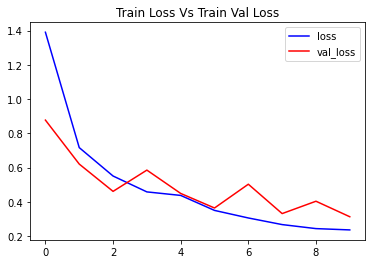

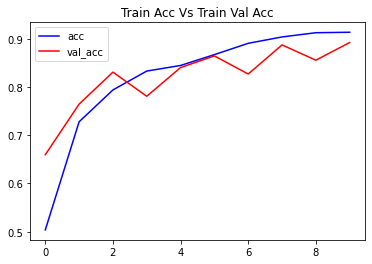

In [ ]:
main_plot(history)

In [ ]:
main_testing(x_test, y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)             12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_______________________

In [ ]:
main_mfcc_figure()

yu_zhu_qi.json  have plot.  
 Located:  /content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/FIGURE/yu_zhu_qi/0070.wav
yu_zhu_qi.json  have plot.  
 Located:  /content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/FIGURE/yu_zhu_qi/0074.wav


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>